In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
#from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [41]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

### Load data 

In [42]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [43]:
OB = 'OB1'

In [44]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = np.sort(os.listdir(path))

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3500) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 20)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

error = error #* 2.26

Binning image by a factor: 20


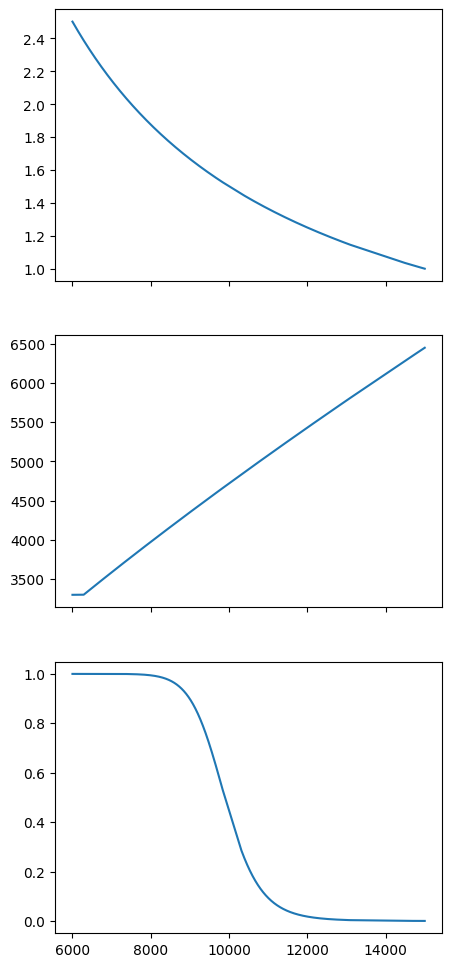

In [6]:
h = 6.626e-34 #SI 4.135e-15
kb = 1.38e-23 #SI
e     = 1.6e-19
eps_0 = 8.85e-12
m_e   = 9.1e-31
c     = 3e8

mu_beta = (10500-wl[(wl>6000) & (wl<15000)])/10500
t_obs = 1.43
t = t_obs/(1-mu_beta) 

T_phys = 4900 * (t/1.43)**(-0.77)
T_phys[T_phys<3300] = 3300
n_e = 1e9 * 1e6

lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
rat_1 = (ni_over_n0/(1+ni_over_n0))

nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
rat_2 = (nii_over_ni/(1+nii_over_ni))
    
frac_2nd = ( rat_1*(1-np.array(rat_2)) )

fig, ax = plt.subplots( figsize=(5,12), nrows=3, sharex=True )

ax[0].plot(wl[(wl>6000) & (wl<15000)], t)
ax[1].plot(wl[(wl>6000) & (wl<15000)], T_phys)
ax[2].plot(wl[(wl>6000) & (wl<15000)], frac_2nd)

from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=50 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

#@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, tau2 = 0.0, lam2=7000, tau3=0.0, lam3 = 10000, logne=9, 
                    t_crit=1.43): #blackbody

    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10500,vref=vref, ve=ve , t0=t0)

    #pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    #pcyg_prof_novel2 = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    
    correction = pcyg_prof4*pcyg_prof3*pcyg_prof5#*pcyg_prof_novel*pcyg_prof_novel2
    
    mu_beta = (10500e-10-wav[(wav>6000e-10) & (wav<15000e-10)])/10500e-10
    t_obs = 1.43
    t = t_obs /(1-mu_beta)
    
    T_phys = 4100 * (t/ (t_obs+9.5/24) )**(-0.54) * (t_obs/t_crit)**(0.54)
    T_phys[T_phys<3300] = 3300
    n_e = 10**(logne) * 1e6

    lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
    ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
    rat_1 = (ni_over_n0/(1+ni_over_n0))

    nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
    rat_2 = (nii_over_ni/(1+nii_over_ni))
    
    frac_2nd = ( rat_1*(1-np.array(rat_2)) ) 
    


    #print(T_phys)
    #print(frac_2nd)
    correction[(wav>6000e-10) & (wav<15000e-10)] = (correction[(wav>6000e-10) & (wav<15000e-10)]-1)*frac_2nd + 1
        
    T_phys_n = T * (t/ (t_obs+11/24) )**(-0.54)
    flux_ratio = temp(wav[(wav>6000e-10) & (wav<15000e-10)],T_phys_n)/temp(wav[(wav>6000e-10) & (wav<15000e-10)], T)
    correction[(wav>6000e-10) & (wav<15000e-10)] = 1 + (correction[(wav>6000e-10) & (wav<15000e-10)]-1)*flux_ratio
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    logne = v["logne"]
    
    t_crit = v["t_crit"]
    #tau2, lam2 = v["tau2"], v["lam2"]
    #tau3, lam3 = v["tau3"], v["lam3"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, logne=logne, 
                           t_crit=t_crit) #, 
                           #tau2=tau2, lam2=lam2, tau3=tau3, lam3=lam3)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart_2.txt')
inter = interp1d(beta, doppler)
c = 3.0e+8
    
def lum_dist_arr(N, vphot, v_perp, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = v_perp*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


n_days = [1.427, 2.417, 3.413, 4.403]

#plt.ylim(-1e-10, 1e-10)

In [88]:
1.43*(1-700/1050)*24

11.440000000000001

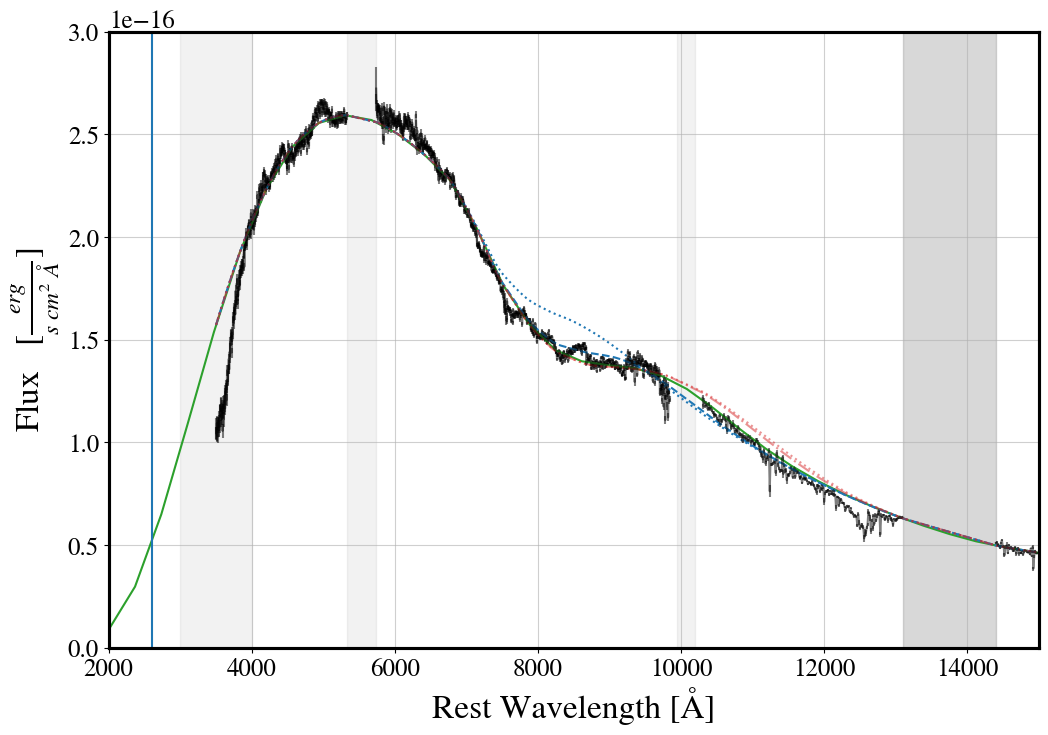

In [50]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
plt.errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter spectra', color='k', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

wli = np.linspace(2000, 20000)

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.45, min=0, max=2)
p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
plt.plot(wli, residual(p, wli*1e-10), color='C2' )
p_c = p
p_c['logne'].value = 8
plt.plot(wl, residual(p_c, wl*1e-10), ls='--', color='C0', label='' )

p_c = p
p_c['logne'].value = 7
plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=1, color='C0' )

#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
plt.plot(wl, residual(p_c, wl*1e-10), ls='-.', alpha=0.5, color='C3' )

p_c = p
p_c['logne'].value = 11
plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=0.5, color='C3' )

plt.xlim(2000, 15000)
#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

plt.axvline(2600)
#plt.savefig('Pictures/UV-extrapolation.png', dpi=300)

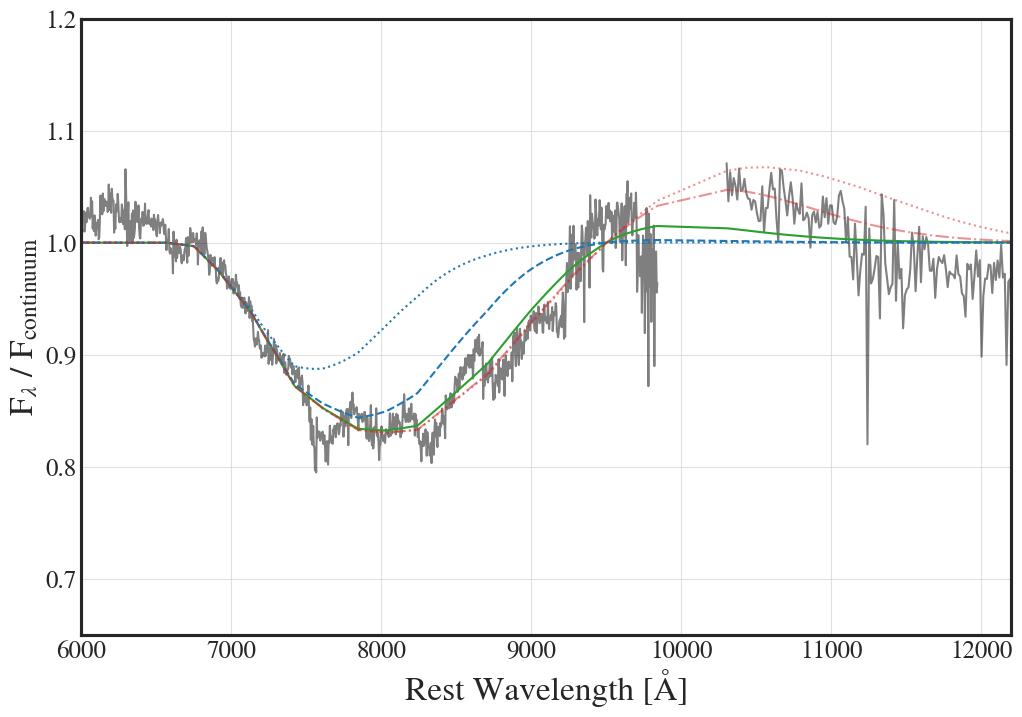

In [199]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl, flux/residual(p_continuum, wl*1e-10), label='X-shooter spectra', color='grey', alpha=0.5)
plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter spectra', color='k', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
#plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
plt.plot(wl, residual(p, wl*1e-10)/residual(p_continuum, wl*1e-10), color='C2' )
p_c = p
p_c['logne'].value = 8
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='--', color='C0' )

p_c = p
p_c['logne'].value = 7
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='dotted', alpha=1, color='C0' )

#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-.', alpha=0.5, color='C3' )

p_c = p
p_c['logne'].value = 11
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='dotted', alpha=0.5, color='C3' )

plt.xlim(6000, 12200)
plt.ylim(0.65, 1.2)
#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_ne.png', dpi=300)

(0.65, 1.2)

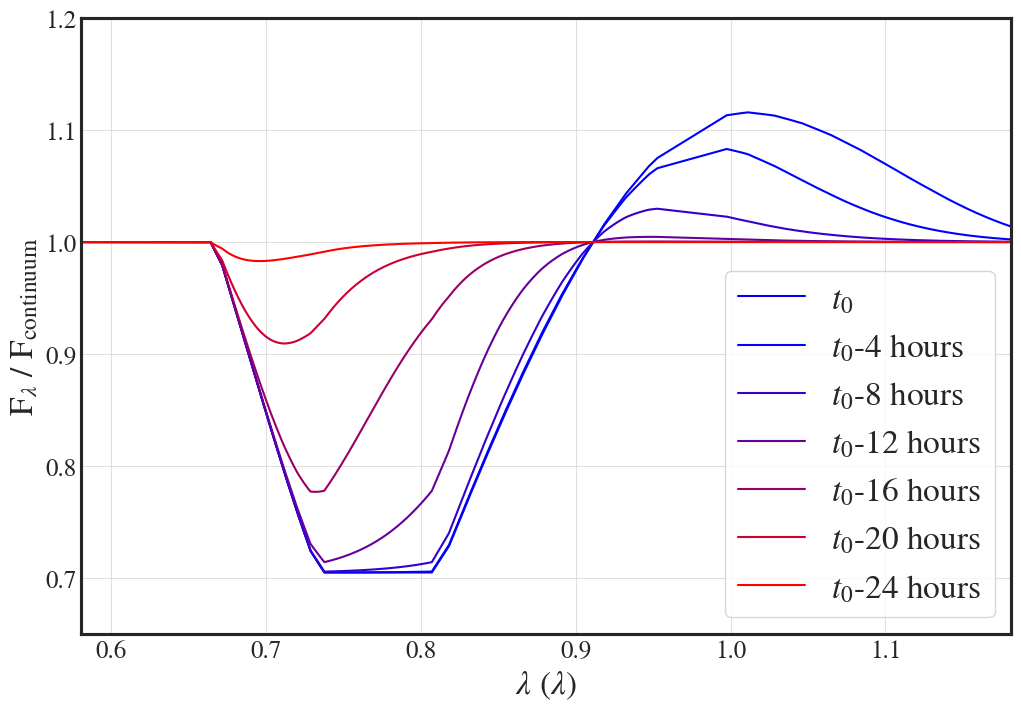

In [301]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))

plt.xlabel('$\lambda$ ($\lambda$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)

p_c = p
p_c['logne'].value =11
#p_c['t0'].value = 1.45
plt.plot(wl/10327.311, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[0/5, 0, 1-0/5], label='$t_0$')

for idx,index in enumerate([5,6,7,8,9,10][::-1]):
    p_c = p
    p_c['logne'].value =index
    plt.plot(wl/10327.311, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[idx/5, 0, 1-idx/5], label='$t_0$'+str( 4*(index-11) )+' hours')

plt.legend(frameon=True)
plt.xlim(6000/10327.311, 12200/10327.311)
plt.ylim(0.65, 1.2)
#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_ne.png', dpi=300)

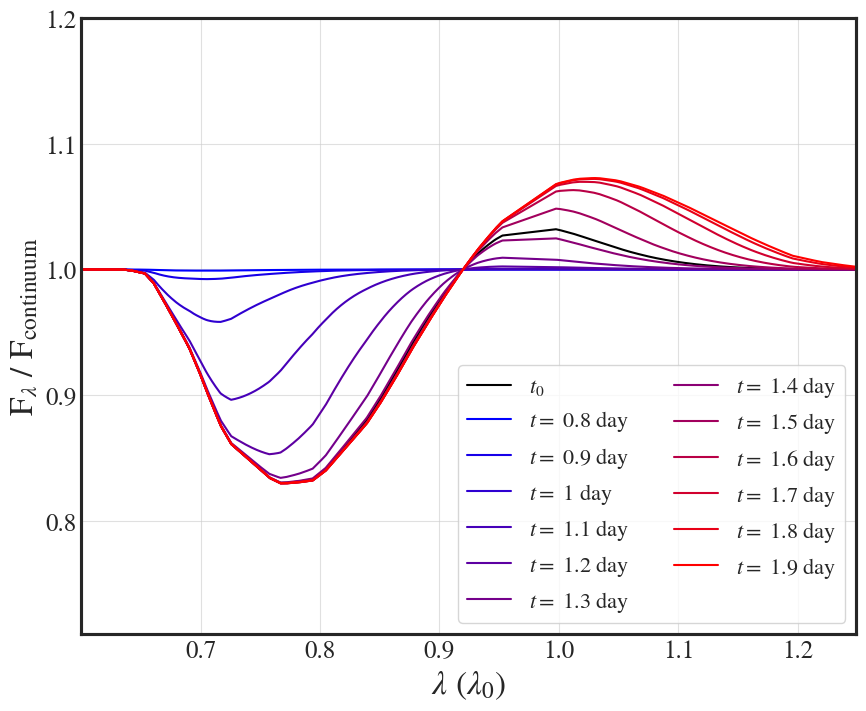

In [50]:
reset_plt(18,24)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(10,8))

p_c = p
p_c['logne'].value =9.7
p_c['t_crit'].value = 1.43
plt.plot(wl/10327.311, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[0, 0, 0], label='$t_0$')

for idx,index in enumerate([0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]):
    p_c['t_crit'].value = index
    plt.plot(wl/10327.311, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11], label='$t = $ '+str( index )+' day')

    plt.legend(frameon=True, fontsize=16, ncol=2, loc=4)
    plt.xlim(6200/10327.311, 12900/10327.311)
    plt.ylim(0.71, 1.2)
    plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    ax.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
#plt.plot(wl_bin/10327.311, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter spectra', color='k', alpha=0.5)   


#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_ne.png', dpi=300)



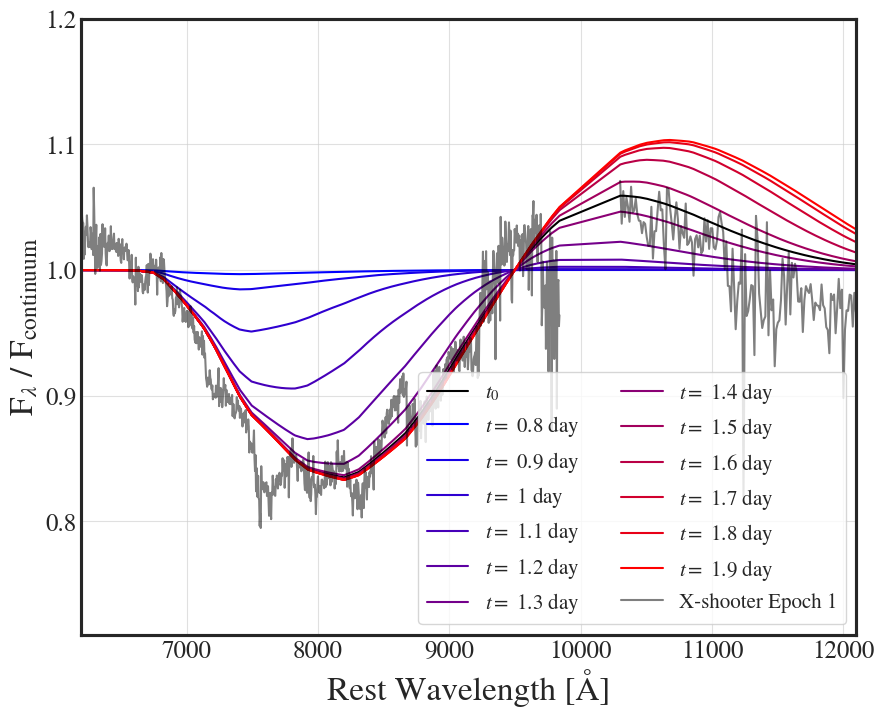

In [22]:
reset_plt(18,24)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(10,8))

p_c = p
p_c['logne'].value =9
p_c['t_crit'].value = 1.45
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[0, 0, 0], label='$t_0$')

for idx,index in enumerate([0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11], label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12100)
    plt.ylim(0.71, 1.2)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    ax.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=4)


#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_ne.png', dpi=300)



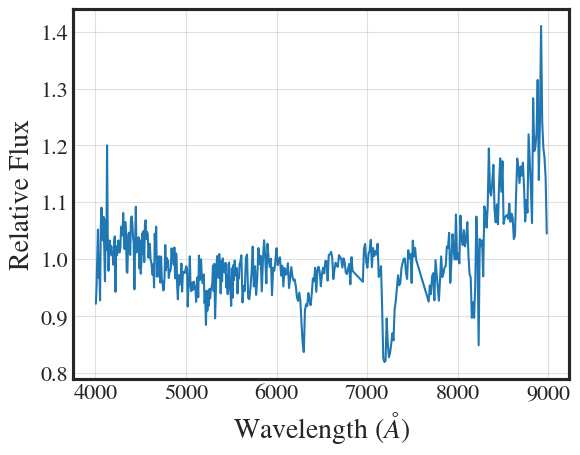

In [83]:
from astropy.io import ascii

def plot_spec(fig, ax, rat=1, col=''):
    # Plot the spectrum
    t = ascii.read(filename)
    # Rename the columns
    t.rename_column("col1", "wav")
    t.rename_column("col2", "flux")
    # Plot
    wav = t['wav'][:-7]
    flux = t['flux'][:-7]
    
    flux = np.reshape(flux, (int(np.shape(flux)[0]/10), 10) )
    wav = np.reshape(wav, (int(np.shape(wav)[0]/10), 10) )
    flux = np.mean(flux,axis=1)
    wav = np.mean(wav,axis=1)
    
    exc_reg = (~((wav > 7550) & (wav < 7670))) &  (~((wav > 6850) & (wav < 6950))) 
    
    #ax.plot(t['wav'], t['flux'], col+'-')
    #ax.plot(wav[exc_reg], rat*flux[exc_reg], color=col, label='0.93 days (ANU WiFeS)')
    # Labels
    ax.set_xlabel(r"Wavelength ($\AA$)")
    ax.set_ylabel("Relative Flux")
    ax.ticklabel_format(axis='x', style='plain')

    return fig, ax, wav[exc_reg], flux[exc_reg]


if __name__ == "__main__":

    # Data
    filename = '../Spectral Series (AT2017gfo)/anufit_spectrum_dered.dat'
    fig, ax = plt.subplots()
    fig, ax, wl,flux = plot_spec(fig, ax, col='b')
    
ax.plot(wl, flux/(1.6e-13*6.4*temp(wl*1e-10, 6200)) )

In [60]:
os.listdir('../Spectral Series (AT2017gfo)/')

['Spectral_series_093-144_wideformat_2.png',
 'pcygni_5.py',
 'SSS17a-LDSS3-20170817_cal.flm',
 'SALT_Crawford.txt',
 'Temp_in_time_2.png',
 'Spectral_series_09-14.png',
 '__pycache__',
 'SSS17a-MagE-20170817_cal.flm',
 'anufit_spectrum_dered.dat',
 'Spectral_series_093-144_wideformat.png',
 'anu2.3m_WiFeS.dat',
 'ANU & SALT.ipynb',
 '.ipynb_checkpoints',
 'Spectral series.ipynb',
 'SALT_ANU_spectra.png',
 'Temp_in_time.png']

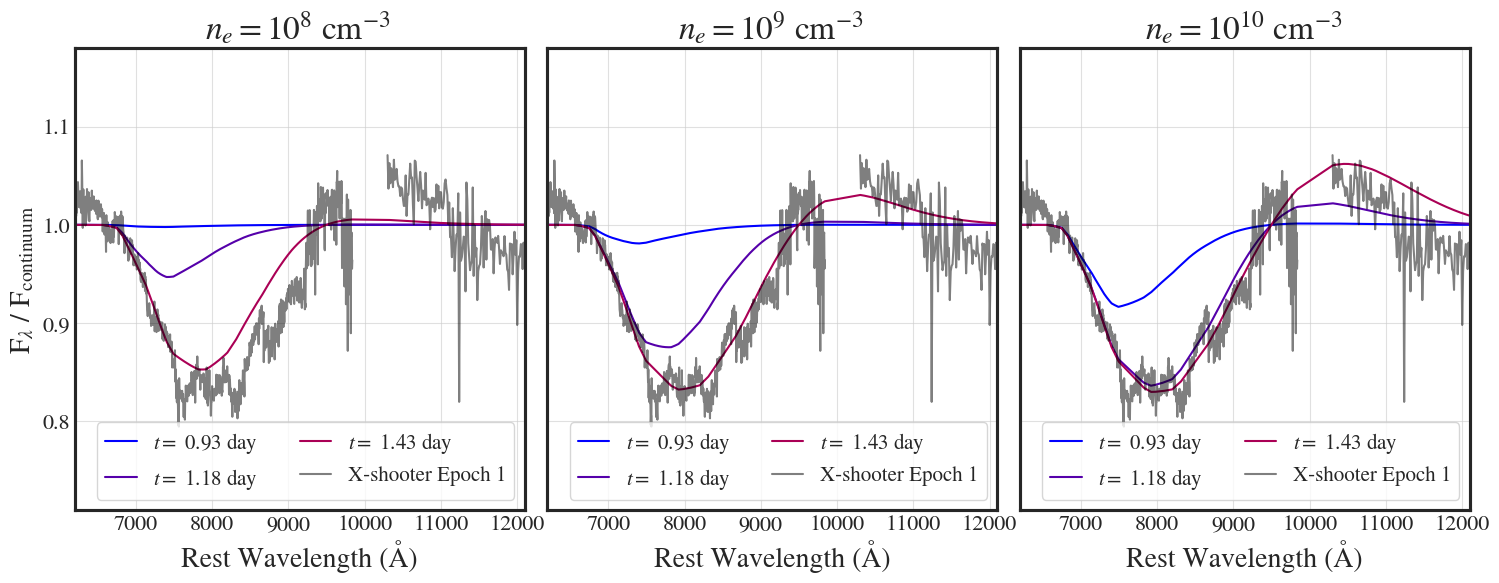

In [118]:
reset_plt(16,20)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(18,6), ncols=3, sharey=True, sharex=True)

p_c = p
p_c['logne'].value = 9
p_c['t_crit'].value = 1.43
#plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
#            color=[0, 0, 0], label='$t_0$')
for jdex, ne in enumerate([8,9,10]):
    p_c['logne'].value = ne
    for idx,index in enumerate([0.93, 1.18, 1.43]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
        p_c['t_crit'].value = index
        ax[jdex].plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
                color=[idx/3, 0, 1-idx/3], label='$t = $ '+str( index )+' day')

        plt.xlim(6200, 12100)
        plt.ylim(0.71, 1.18)
        #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
        ax[jdex].ticklabel_format(axis='x', style='plain')
    
    ax[jdex].plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
    ax[jdex].legend(frameon=True, fontsize=15, ncol=2, loc=4, handlelength=1.5)
    ax[jdex].set_xlabel('Rest Wavelength (Å)')
    
ax[0].set_ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 

#ax[0].set_title(r'$\log(n_e \ \ {\rm \frac{g}{cm^{3}} } ) = 8$')
#ax[0].set_title(r'$n_e = 10^8 \ {\rm \frac{g}{cm^{3}} } $', fontsize=22)
#ax[1].set_title(r'$n_e = 10^9 \ {\rm \frac{g}{cm^{3}} } $')
#ax[2].set_title(r'$n_e = 10^{10} \ {\rm \frac{g}{cm^{3}} } $')
ax[0].set_title(r'$n_e = 10^{8} \ {\rm cm^{-3} } $')
ax[1].set_title(r'$n_e = 10^{9} \ {\rm cm^{-3} } $')
ax[2].set_title(r'$n_e = 10^{10} \ {\rm cm^{-3} } $')

#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
plt.subplots_adjust(wspace=0.05)
#plt.savefig('Pictures/First_epoch_ratio_logne_8-9-10.png', dpi=300)

#ax[0].plot(wl, flux/(1.6e-13*6.4*temp(wl*1e-10, 6200)) )

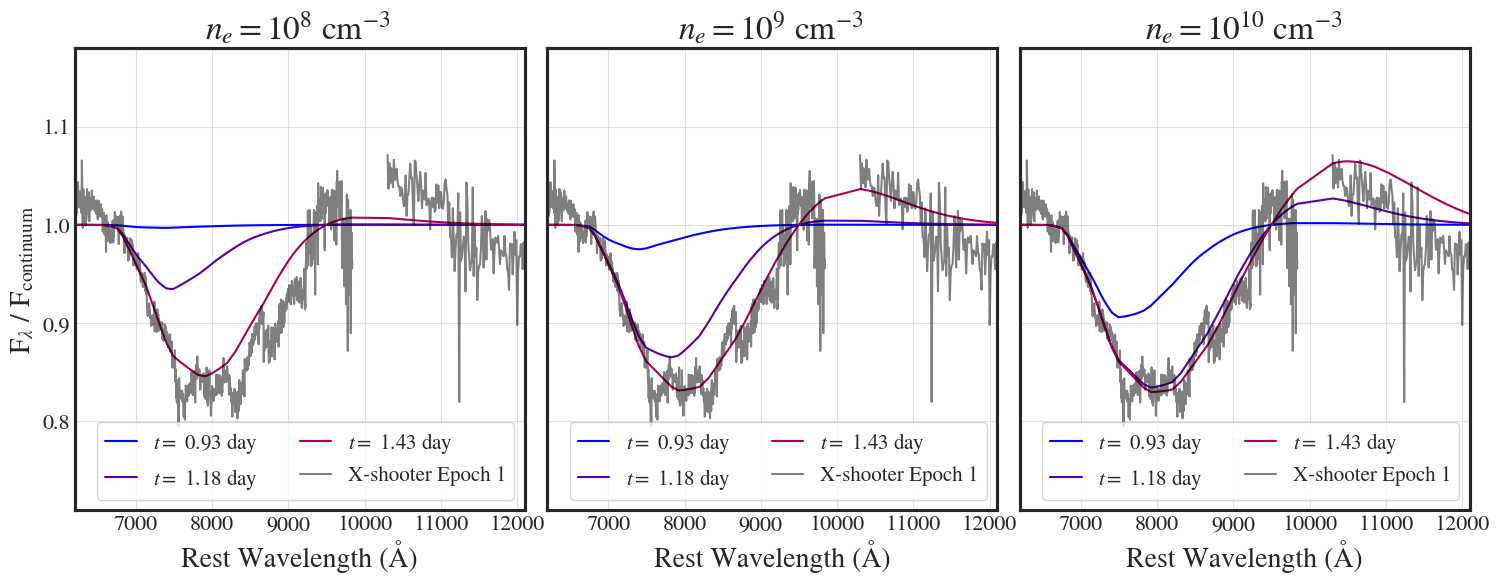

In [164]:
reset_plt(16,20)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(18,6), ncols=3, sharey=True, sharex=True)

p_c = p
p_c['logne'].value = 9
p_c['t_crit'].value = 1.43
#plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
#            color=[0, 0, 0], label='$t_0$')
for jdex, ne in enumerate([8,9,10]):
    p_c['logne'].value = ne
    for idx,index in enumerate([0.93, 1.18, 1.43]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
        p_c['t_crit'].value = index
        ax[jdex].plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
                color=[idx/3, 0, 1-idx/3], label='$t = $ '+str( index )+' day')

        plt.xlim(6200, 12100)
        plt.ylim(0.71, 1.18)
        #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
        ax[jdex].ticklabel_format(axis='x', style='plain')
    
    ax[jdex].plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
    ax[jdex].legend(frameon=True, fontsize=15, ncol=2, loc=4, handlelength=1.5)
    ax[jdex].set_xlabel('Rest Wavelength (Å)')
    
ax[0].set_ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 

#ax[0].set_title(r'$\log(n_e \ \ {\rm \frac{g}{cm^{3}} } ) = 8$')
#ax[0].set_title(r'$n_e = 10^8 \ {\rm \frac{g}{cm^{3}} } $', fontsize=22)
#ax[1].set_title(r'$n_e = 10^9 \ {\rm \frac{g}{cm^{3}} } $')
#ax[2].set_title(r'$n_e = 10^{10} \ {\rm \frac{g}{cm^{3}} } $')
ax[0].set_title(r'$n_e = 10^{8} \ {\rm cm^{-3} } $')
ax[1].set_title(r'$n_e = 10^{9} \ {\rm cm^{-3} } $')
ax[2].set_title(r'$n_e = 10^{10} \ {\rm cm^{-3} } $')

#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
plt.subplots_adjust(wspace=0.05)
#plt.savefig('Pictures/First_epoch_ratio_logne_8-9-10_Tpower077.png', dpi=300)

#ax[0].plot(wl, flux/(1.6e-13*6.4*temp(wl*1e-10, 6200)) )

In [ ]:
reset_plt(16,20)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(18,6), ncols=3, sharey=True, sharex=True)

p_c = p
p_c['logne'].value = 9
p_c['t_crit'].value = 1.43
#plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
#            color=[0, 0, 0], label='$t_0$')
for jdex, ne in enumerate([8,9,10]):
    p_c['logne'].value = ne
    for idx,index in enumerate([0.93, 1.18, 1.43]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
        p_c['t_crit'].value = index
        ax[jdex].plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
                color=[idx/3, 0, 1-idx/3], label='$t = $ '+str( index )+' day')

        plt.xlim(6200, 12100)
        plt.ylim(0.71, 1.18)
        #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
        ax[jdex].ticklabel_format(axis='x', style='plain')
    
    ax[jdex].plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
    ax[jdex].legend(frameon=True, fontsize=15, ncol=2, loc=4, handlelength=1.5)
    ax[jdex].set_xlabel('Rest Wavelength (Å)')
    
ax[0].set_ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 

#ax[0].set_title(r'$\log(n_e \ \ {\rm \frac{g}{cm^{3}} } ) = 8$')
#ax[0].set_title(r'$n_e = 10^8 \ {\rm \frac{g}{cm^{3}} } $', fontsize=22)
#ax[1].set_title(r'$n_e = 10^9 \ {\rm \frac{g}{cm^{3}} } $')
#ax[2].set_title(r'$n_e = 10^{10} \ {\rm \frac{g}{cm^{3}} } $')
ax[0].set_title(r'$n_e = 10^{8} \ {\rm cm^{-3} } $')
ax[1].set_title(r'$n_e = 10^{9} \ {\rm cm^{-3} } $')
ax[2].set_title(r'$n_e = 10^{10} \ {\rm cm^{-3} } $')

#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
plt.subplots_adjust(wspace=0.05)
#plt.savefig('Pictures/First_epoch_ratio_logne_8-9-10_Tpower077.png', dpi=300)

#ax[0].plot(wl, flux/(1.6e-13*6.4*temp(wl*1e-10, 6200)) )

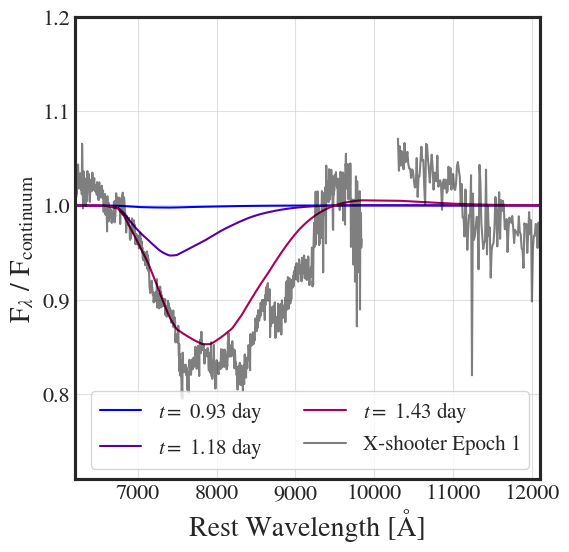

In [39]:
reset_plt(16,20)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(6,6))

p_c = p
p_c['logne'].value = 8
p_c['t_crit'].value = 1.43
#plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
#            color=[0, 0, 0], label='$t_0$')

for idx,index in enumerate([0.93, 1.18, 1.43]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[idx/3, 0, 1-idx/3], label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12100)
    plt.ylim(0.71, 1.2)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    ax.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=4)


#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_logne_9.png', dpi=300)



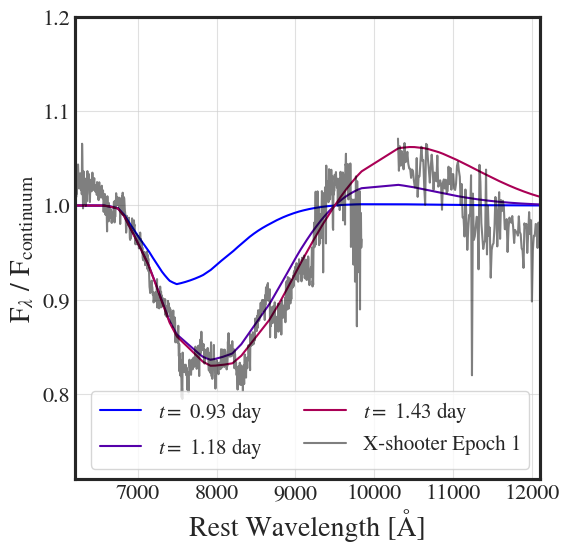

In [40]:
reset_plt(16,20)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(6,6))

p_c = p
p_c['logne'].value = 10
p_c['t_crit'].value = 1.43
#plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
#            color=[0, 0, 0], label='$t_0$')

for idx,index in enumerate([0.93, 1.18, 1.43]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-', alpha=1, 
            color=[idx/3, 0, 1-idx/3], label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12100)
    plt.ylim(0.71, 1.2)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    ax.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=4)


#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_logne_10.png', dpi=300)



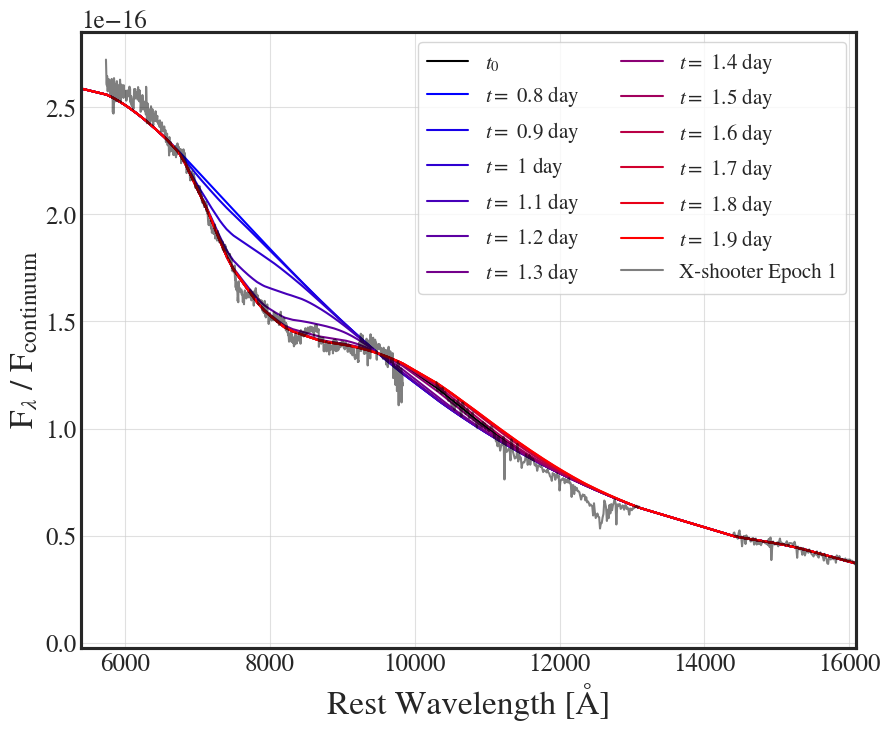

In [68]:
reset_plt(18,24)

#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)
fig,ax = plt.subplots(figsize=(10,8))

p_c = p
p_c['logne'].value =10
p_c['t_crit'].value = 1.45
plt.plot(wl, residual(p_c, wl*1e-10)#/residual(p_continuum, wl*1e-10)
         , ls='-', alpha=1, 
            color=[0, 0, 0], label='$t_0$')

for idx,index in enumerate([0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    plt.plot(wl, residual(p_c, wl*1e-10)#/residual(p_continuum, wl*1e-10)
             , ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11], label='$t = $ '+str( index )+' day')

    plt.xlim(5400, 16100)
    #plt.ylim(0.71, 1.2)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    ax.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
plt.plot(wl_bin, f_bin#/residual(p_continuum, wl_bin*1e-10)
         , label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=1)


#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)
#plt.savefig('Pictures/First_epoch_ratio_ne.png', dpi=300)



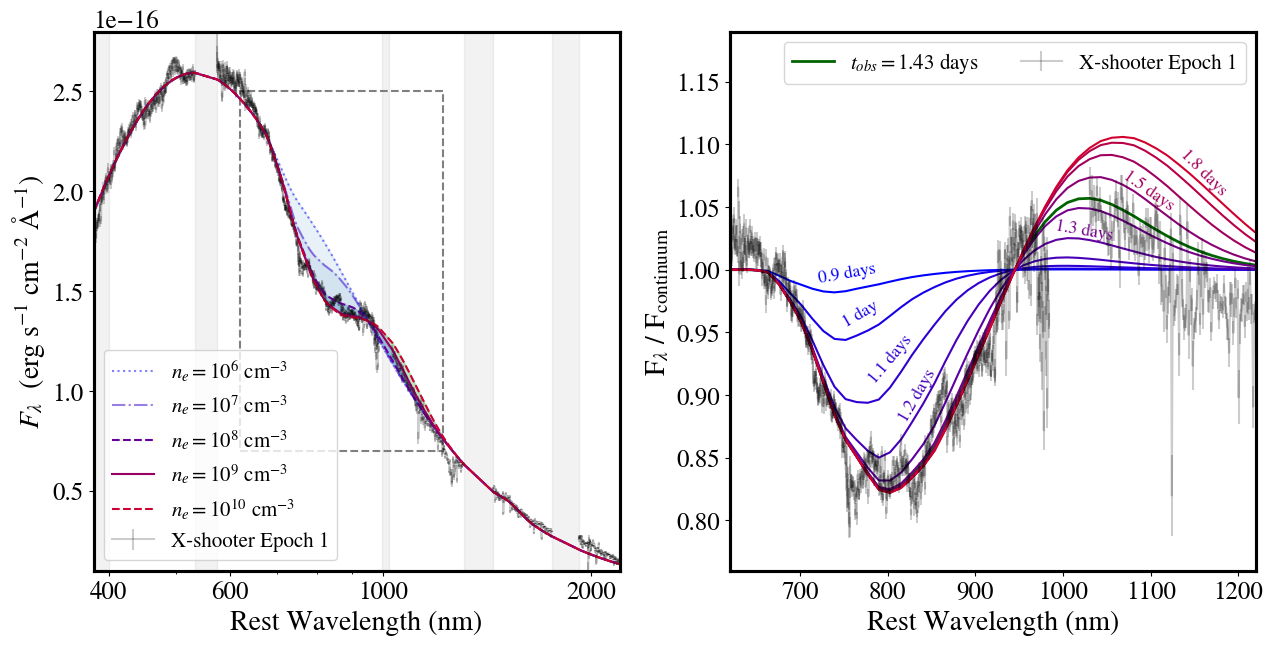

In [40]:
reset_plt(18,20)
#fig,ax = plt.subplots(figsize=(14,7), ncols=2)
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax = [ax1, ax2]

#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
ax[0].errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter Epoch 1', color='k', alpha=0.2)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)

#define telluric region
ax[0].fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )
ax[0].fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )

#poorly constrained regions
ax[0].fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax[0].fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax[0].fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

ax[0].set_xlabel('Rest Wavelength (nm)'), ax[0].set_ylabel(r'$F_{\lambda}$  ${\rm ( erg \ s^{-1} \ cm^{-2} \ Å^{-1} ) }$'), 
ax[0].ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['amp2'].value = 0
p.add('t_crit', value=1.45, min=0, max=2)
p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
#typ = residual(p, wl*1e-10)
#ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4] )

p_c = p
p_c['logne'].value = 6
low_6 = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=0.5, color=[0, 0, 1], label='$n_e=10^{6}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 7
low = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='-.', alpha=0.5, color=[0.2, 0, 0.8], label='$n_e=10^{7}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 8
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', color=[0.4, 0, 0.6], label='$n_e=10^{8}$ cm$^{-3}$' )
low_8 = residual(p_c, wl*1e-10)

p_c['logne'].value = 9
typ = residual(p, wl*1e-10)
ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4], label='$n_e=10^{9}$ cm$^{-3}$' )


#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', alpha=1, color=[0.8, 0, 0.2], label='$n_e=10^{10}$ cm$^{-3}$' )
high = residual(p_c, wl*1e-10)


ax[0].fill_between(wl, low, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_6, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_8, typ, color='C0', alpha=0.3)
ax[0].fill_between(wl, typ, high, color='C2', alpha=0.3)

ax[0].set_ylim(0.1e-16, 2.8e-16)
ax[0].set_xlim(3800, 22000)
ax[0].set_xscale('log')
ax[0].legend(frameon=True, fontsize=15, ncol=1, loc=3)

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

#### Residual form

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.45, min=0, max=2)
#p.add_parameters('logne', 9)

p_c = p
p_c['tau'].value = 18
p_c['vmax'].value = 0.355
    
p_c['logne'].value =9.0
p_c['t_crit'].value = 1.43
plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color='Darkgreen', label='$t_{obs} = 1.43$ days', linewidth=2)

for idx,index in enumerate([0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    
    plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11])#, label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12200)
    plt.ylim(0.76, 1.19)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    plt.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
#plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.errorbar(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), yerr= f_err_bin/residual(p_continuum, wl_bin*1e-10)
             ,label='X-shooter Epoch 1', color='k', alpha=0.2)   
plt.xlabel('Rest Wavelength (nm)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=1)


# Our cooling
#ax[1].text(7150, 1.00 , '0.9 days', color=[0/11, 0, 1-0/11], fontsize=12.5, rotation= 0)
#ax[1].text(7400, 0.97 , '1 day'   , color=[1/11, 0, 1-1/11], fontsize=12.5, rotation=30)
#ax[1].text(7750, 0.92  , '1.1 days', color=[2/11, 0, 1-2/11], fontsize=12.5, rotation=60)
#ax[1].text(8100, 0.88 , '1.2 days', color=[3/11, 0, 1-3/11], fontsize=12.5, rotation=70)

#ax[1].text(9900, 1.014 , '1.3 days', color=[5/11, 0, 1-5/11], fontsize=12.5, rotation=-10 )
#ax[1].text(10650, 1.048 , '1.5 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-45 )
#ax[1].text(11300, 1.075 , '1.8 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-55 )

ax[1].text(7200, 0.99 , '0.9 days', color=[0/11, 0, 1-0/11], fontsize=12.5, rotation= 10)
ax[1].text(7450, 0.955 , '1 day'   , color=[1/11, 0, 1-1/11], fontsize=12.5, rotation=30)
ax[1].text(7750, 0.91  , '1.1 days', color=[2/11, 0, 1-2/11], fontsize=12.5, rotation=50)
ax[1].text(8100, 0.88 , '1.2 days', color=[3/11, 0, 1-3/11], fontsize=12.5, rotation=60)

ax[1].text(9900, 1.024 , '1.3 days', color=[5/11, 0, 1-5/11], fontsize=12.5, rotation=-10 )
ax[1].text(10650, 1.048 , '1.5 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-35 )
ax[1].text(11300, 1.06 , '1.8 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-45 )

ax[1].grid()
ax[0].grid()

## Adding plotting connecting subplots

import matplotlib.patches as patches
rect = patches.Rectangle( (ax[1].get_xlim()[0], 0.7e-16), 
                         ax[1].get_xlim()[1]-ax[1].get_xlim()[0], 
                         1.8e-16, 
                         linewidth=1.5, edgecolor='grey', facecolor='none', linestyle='--')

ax[0].add_patch(rect)

from matplotlib.patches import ConnectionPatch
#xy1 = (ax[1].get_xlim()[1],0.7e-16)
#xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[0])
#con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
#                      axesA=ax1, axesB=ax2, color="grey", ls='--')
#ax2.add_artist(con)

#xy1 = (ax[1].get_xlim()[1],0.7e-16+1.8e-16)
#xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[1])
#con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
#                      axesA=ax1, axesB=ax2, color="grey", ls='--')
#ax2.add_artist(con)


ax[0].set_xticks(ticks=[4000, 6000, 10000, 20000], 
           labels=['400', '600', '1000', '2000'])

ax[1].set_xticks(ticks=[7000, 8000, 9000, 10000, 11000, 12000], 
           labels=['700', '800', '900', '1000', '1100', '1200'])

plt.subplots_adjust(wspace=0.21, hspace=None)

#plt.show()
#plt.savefig('Pictures/First_epoch_reverberation_wave_with_flouresence.png', dpi=300)

In [25]:
chi = (flux-residual(p_c, wl*1e-10))**2/error**2
chi_without = (flux-residual(p_continuum, wl*1e-10))**2/error**2
np.mean(chi[(wl>6800) & (wl<12000)]), np.mean(chi_without[(wl>6800) & (wl<12000)])

(2.471520521244293, 27.391055293148376)

In [26]:
np.sum(chi_without[(wl>6800) & (wl<12000)])-np.sum(chi[(wl>6800) & (wl<12000)])

453709.96959205763

In [27]:
len(chi[(wl>6800) & (wl<12000)])

18207

In [11]:
p_c

name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,19.8889462,4.75750986,(23.92%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


In [58]:
11.4/24

0.47500000000000003

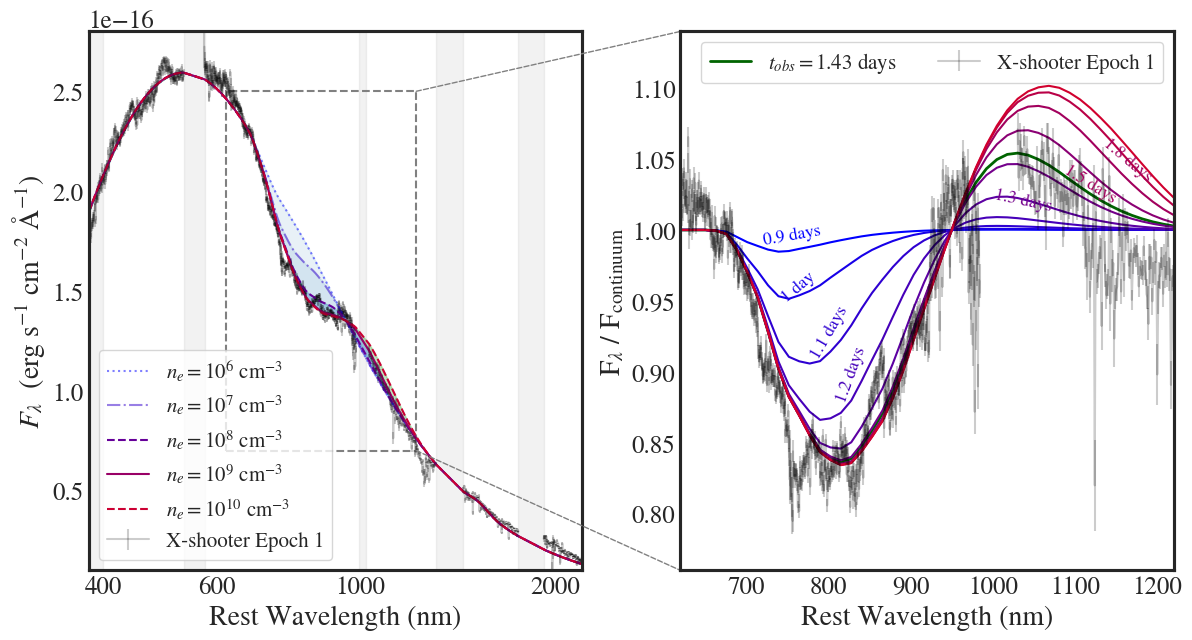

In [24]:
reset_plt(18,20)
#fig,ax = plt.subplots(figsize=(14,7), ncols=2)
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax = [ax1, ax2]

#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
ax[0].errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter Epoch 1', color='k', alpha=0.2)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)

#define telluric region
ax[0].fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )
ax[0].fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )

#poorly constrained regions
ax[0].fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax[0].fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax[0].fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

ax[0].set_xlabel('Rest Wavelength (nm)'), ax[0].set_ylabel(r'$F_{\lambda}$  ${\rm ( erg \ s^{-1} \ cm^{-2} \ Å^{-1} ) }$'), 
ax[0].ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['amp2'].value = 0
p.add('t_crit', value=1.45, min=0, max=2)
p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
#typ = residual(p, wl*1e-10)
#ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4] )

p_c = p
p_c['logne'].value = 6
low_6 = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=0.5, color=[0, 0, 1], label='$n_e=10^{6}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 7
low = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='-.', alpha=0.5, color=[0.2, 0, 0.8], label='$n_e=10^{7}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 8
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', color=[0.4, 0, 0.6], label='$n_e=10^{8}$ cm$^{-3}$' )
low_8 = residual(p_c, wl*1e-10)

p_c['logne'].value = 9
typ = residual(p, wl*1e-10)
ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4], label='$n_e=10^{9}$ cm$^{-3}$' )


#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', alpha=1, color=[0.8, 0, 0.2], label='$n_e=10^{10}$ cm$^{-3}$' )
high = residual(p_c, wl*1e-10)


ax[0].fill_between(wl, low, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_6, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_8, typ, color='C0', alpha=0.3)
ax[0].fill_between(wl, typ, high, color='C2', alpha=0.3)

ax[0].set_ylim(0.1e-16, 2.8e-16)
ax[0].set_xlim(3800, 22000)
ax[0].set_xscale('log')
ax[0].legend(frameon=True, fontsize=15, ncol=1, loc=3)

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

#### Residual form

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.43, min=0, max=2)
#p.add_parameters('logne', 9)

p_c = p
p_c['logne'].value =9.0
p_c['t_crit'].value = 1.43
plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color='Darkgreen', label='$t_{obs} = 1.43$ days', linewidth=2)

for idx,index in enumerate([0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    p_c['t_crit'].value = index
    plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11])#, label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12200)
    plt.ylim(0.76, 1.14)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    plt.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
#plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.errorbar(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), yerr= f_err_bin/residual(p_continuum, wl_bin*1e-10)
             ,label='X-shooter Epoch 1', color='k', alpha=0.2)   
plt.xlabel('Rest Wavelength (nm)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=1)



ax[1].text(7200, 0.99 , '0.9 days', color=[0/11, 0, 1-0/11], fontsize=12.5, rotation=10)
ax[1].text(7400, 0.95 , '1 day'   , color=[1/11, 0, 1-1/11], fontsize=12.5, rotation=40)
ax[1].text(7750, 0.91  , '1.1 days', color=[2/11, 0, 1-2/11], fontsize=12.5, rotation=60)
ax[1].text(8070, 0.88 , '1.2 days', color=[3/11, 0, 1-3/11], fontsize=12.5, rotation=70)

ax[1].text(10000, 1.014 , '1.3 days', color=[5/11, 0, 1-5/11], fontsize=12.5, rotation=-12 )
ax[1].text(10830, 1.02 , '1.5 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-32 )
ax[1].text(11300, 1.035 , '1.8 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-40 )
ax[1].grid()
ax[0].grid()

## Adding plotting connecting subplots

import matplotlib.patches as patches
rect = patches.Rectangle( (ax[1].get_xlim()[0], 0.7e-16), 
                         ax[1].get_xlim()[1]-ax[1].get_xlim()[0], 
                         1.8e-16, 
                         linewidth=1.5, edgecolor='grey', facecolor='none', linestyle='--')

ax[0].add_patch(rect)

from matplotlib.patches import ConnectionPatch
xy1 = (ax[1].get_xlim()[1],0.7e-16)
xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[0])
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="grey", ls='--')
ax2.add_artist(con)

xy1 = (ax[1].get_xlim()[1],0.7e-16+1.8e-16)
xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[1])
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="grey", ls='--')

ax2.add_artist(con)


ax[0].set_xticks(ticks=[4000, 6000, 10000, 20000], 
           labels=['400', '600', '1000', '2000'])

ax[1].set_xticks(ticks=[7000, 8000, 9000, 10000, 11000, 12000], 
           labels=['700', '800', '900', '1000', '1100', '1200'])


#plt.show()

#plt.savefig('Pictures/First_epoch_reverberation_wave_Waxman.png', dpi=300)

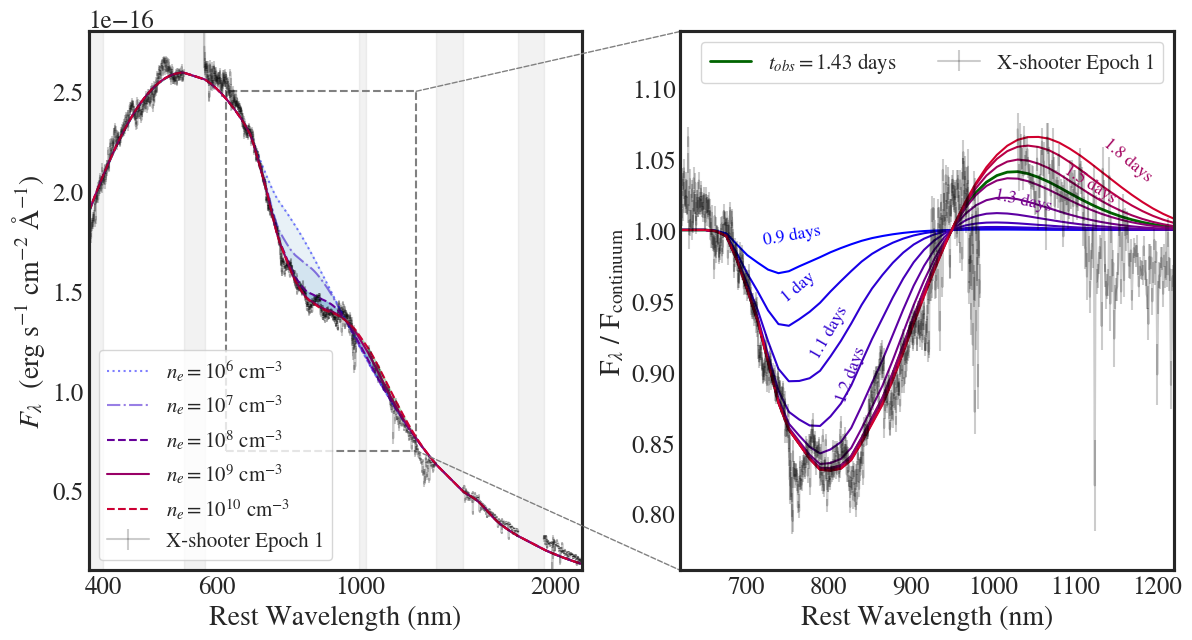

In [169]:
reset_plt(18,20)
#fig,ax = plt.subplots(figsize=(14,7), ncols=2)
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax = [ax1, ax2]

#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
ax[0].errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter Epoch 1', color='k', alpha=0.2)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)

#define telluric region
ax[0].fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )
ax[0].fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1 )

#poorly constrained regions
ax[0].fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax[0].fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax[0].fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

ax[0].set_xlabel('Rest Wavelength (nm)'), ax[0].set_ylabel(r'$F_{\lambda}$  ${\rm ( erg \ s^{-1} \ cm^{-2} \ Å^{-1} ) }$'), 
ax[0].ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['amp2'].value = 0
p.add('t_crit', value=1.45, min=0, max=2)
p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
#typ = residual(p, wl*1e-10)
#ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4] )

p_c = p
p_c['logne'].value = 6
low_6 = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=0.5, color=[0, 0, 1], label='$n_e=10^{6}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 7
low = residual(p_c, wl*1e-10)
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='-.', alpha=0.5, color=[0.2, 0, 0.8], label='$n_e=10^{7}$ cm$^{-3}$' )

p_c = p
p_c['logne'].value = 8
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', color=[0.4, 0, 0.6], label='$n_e=10^{8}$ cm$^{-3}$' )
low_8 = residual(p_c, wl*1e-10)

p_c['logne'].value = 9
typ = residual(p, wl*1e-10)
ax[0].plot(wl, residual(p, wl*1e-10), color=[0.6, 0, 0.4], label='$n_e=10^{9}$ cm$^{-3}$' )


#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
ax[0].plot(wl, residual(p_c, wl*1e-10), ls='--', alpha=1, color=[0.8, 0, 0.2], label='$n_e=10^{10}$ cm$^{-3}$' )
high = residual(p_c, wl*1e-10)


ax[0].fill_between(wl, low, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_6, typ, color='C0', alpha=0.1)
ax[0].fill_between(wl, low_8, typ, color='C0', alpha=0.3)
ax[0].fill_between(wl, typ, high, color='C2', alpha=0.3)

ax[0].set_ylim(0.1e-16, 2.8e-16)
ax[0].set_xlim(3800, 22000)
ax[0].set_xscale('log')
ax[0].legend(frameon=True, fontsize=15, ncol=1, loc=3)

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

#### Residual form

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['tau'].value=100

p.add('logne', value=9, min=5, max=15)
p.add('t_crit', value=1.43, min=0, max=2)
#p.add_parameters('logne', 9)

p_c = p
p_c['logne'].value =9.05
p_c['t_crit'].value = 1.43
plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color='Darkgreen', label='$t_{obs} = 1.43$ days', linewidth=2)

for idx,index in enumerate([0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]):
#for idx,index in enumerate([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]):
    M_sun = 2e33
    t = index*24*3600
    r = 0.25*3e10*t
    vol = 4/3*np.pi*r**3

    mass_of_particle = 80 * 1.67e-24
    fac = 2

    #print(np.log10(fac*(0.05 * M_sun)/vol) , r'g/cm^3', )
    p_c['logne'].value = np.log10(fac*(0.05 * M_sun)/vol/mass_of_particle)
    
    
    p_c['t_crit'].value = index
    plt.plot(np.linspace(6000,12200), residual(p_c, np.linspace(600e-9,1220e-9))/residual(p_continuum, np.linspace(600e-9,1220e-9)), ls='-', alpha=1, 
            color=[idx/11, 0, 1-idx/11])#, label='$t = $ '+str( index )+' day')

    plt.xlim(6200, 12200)
    plt.ylim(0.76, 1.14)
    #plt.xlabel('$\lambda$ ($\lambda_0$)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
    plt.ticklabel_format(axis='x', style='plain')
    
#plt.savefig('Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_'+str(99)+'_final.png', dpi=300)
#plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter Epoch 1', color='k', alpha=0.5)   
plt.errorbar(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), yerr= f_err_bin/residual(p_continuum, wl_bin*1e-10)
             ,label='X-shooter Epoch 1', color='k', alpha=0.2)   
plt.xlabel('Rest Wavelength (nm)'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
plt.legend(frameon=True, fontsize=15, ncol=2, loc=1)



ax[1].text(7200, 0.99 , '0.9 days', color=[0/11, 0, 1-0/11], fontsize=12.5, rotation=10)
ax[1].text(7400, 0.95 , '1 day'   , color=[1/11, 0, 1-1/11], fontsize=12.5, rotation=40)
ax[1].text(7750, 0.91  , '1.1 days', color=[2/11, 0, 1-2/11], fontsize=12.5, rotation=60)
ax[1].text(8070, 0.88 , '1.2 days', color=[3/11, 0, 1-3/11], fontsize=12.5, rotation=70)

ax[1].text(10000, 1.014 , '1.3 days', color=[5/11, 0, 1-5/11], fontsize=12.5, rotation=-12 )
ax[1].text(10830, 1.02 , '1.5 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-32 )
ax[1].text(11300, 1.035 , '1.8 days', color=[7/11, 0, 1-7/11], fontsize=12.5, rotation=-40 )
ax[1].grid()
ax[0].grid()

## Adding plotting connecting subplots

import matplotlib.patches as patches
rect = patches.Rectangle( (ax[1].get_xlim()[0], 0.7e-16), 
                         ax[1].get_xlim()[1]-ax[1].get_xlim()[0], 
                         1.8e-16, 
                         linewidth=1.5, edgecolor='grey', facecolor='none', linestyle='--')

ax[0].add_patch(rect)

from matplotlib.patches import ConnectionPatch
xy1 = (ax[1].get_xlim()[1],0.7e-16)
xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[0])
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="grey", ls='--')
ax2.add_artist(con)

xy1 = (ax[1].get_xlim()[1],0.7e-16+1.8e-16)
xy2 = (ax[1].get_xlim()[0],ax[1].get_ylim()[1])
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color="grey", ls='--')

ax2.add_artist(con)


ax[0].set_xticks(ticks=[4000, 6000, 10000, 20000], 
           labels=['400', '600', '1000', '2000'])

ax[1].set_xticks(ticks=[7000, 8000, 9000, 10000, 11000, 12000], 
           labels=['700', '800', '900', '1000', '1100', '1200'])


#plt.show()

#plt.savefig('Pictures/First_epoch_reverberation_wave_Waxman_with_varying_density.png', dpi=300)

In [152]:
M_sun = 2e33
t = 1.43*24*3600
r = 0.25*3e10*t
vol = 4/3*np.pi*r**3

mass_of_particle = 80 * 1.67e-24
fac = 1

print(np.log10(fac*(0.05 * M_sun)/vol) , r'g/cm^3', )
print(np.log10(fac*(0.05 * M_sun)/vol/mass_of_particle), 'cm^-3') 


-13.5228217393094 g/cm^3
8.351371802551075 cm^-3


In [158]:
np.log10(fac*(0.05 * M_sun))
vol, mass_of_particle

(0.0, 1.336e-22)

In [162]:
(ax[1].get_xlim()[0], ax[1].get_ylim()[0]), ax[1].get_xlim()[1]-ax[1].get_xlim()[0], ax[1].get_ylim()[1]-ax[1].get_ylim()[0],

((6050.0, 0.74), 6050.0, 0.45999999999999996)

In [165]:
ax[0].add_patch(rect)

In [43]:
#import os
#import moviepy.video.io.ImageSequenceClip
#image_folder='Pictures/P_Cygni_Time_Derivative'
#fps=3

#image_files = [os.path.join(image_folder,img)
#               for img in os.listdir(image_folder)
#               if img.endswith(".png")]

#clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip( np.sort(image_files).tolist(), fps=fps)
#clip.write_videofile('Movie_of_Pcygni_evolution_fps3.mp4')

['Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_0.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_1.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_2.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_3.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_4.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_5.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_6.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_7.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_8.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_9.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_91.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_92.png',
 'Pictures/P_Cygni_Time_Derivative/P_cygni_line_emergence_99_final.png']

In [24]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files[::-1], fps=fps)
clip.write_videofile('Movie_of_Pcygni_evolution.mp4')

Moviepy - Building video Movie_of_Pcygni_evolution.mp4.
Moviepy - Writing video Movie_of_Pcygni_evolution.mp4



Moviepy - Done !
Moviepy - video ready Movie_of_Pcygni_evolution.mp4


In [3]:
pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 5.8 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110728 sha256=2c57e466c35fe5d731e98c4827f12df863f3d2c311f40aba2a4722701cc4b30a
  Stored in directory: /Users/asnep1/Library/Caches/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
Note: you may need to restart the kernel to use updated packages.


In [257]:
p_c

name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,1.43000000,,,126000,-inf,inf,False
tau,100.000000,4.75750986,(4.76%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


(0.65, 1.2)

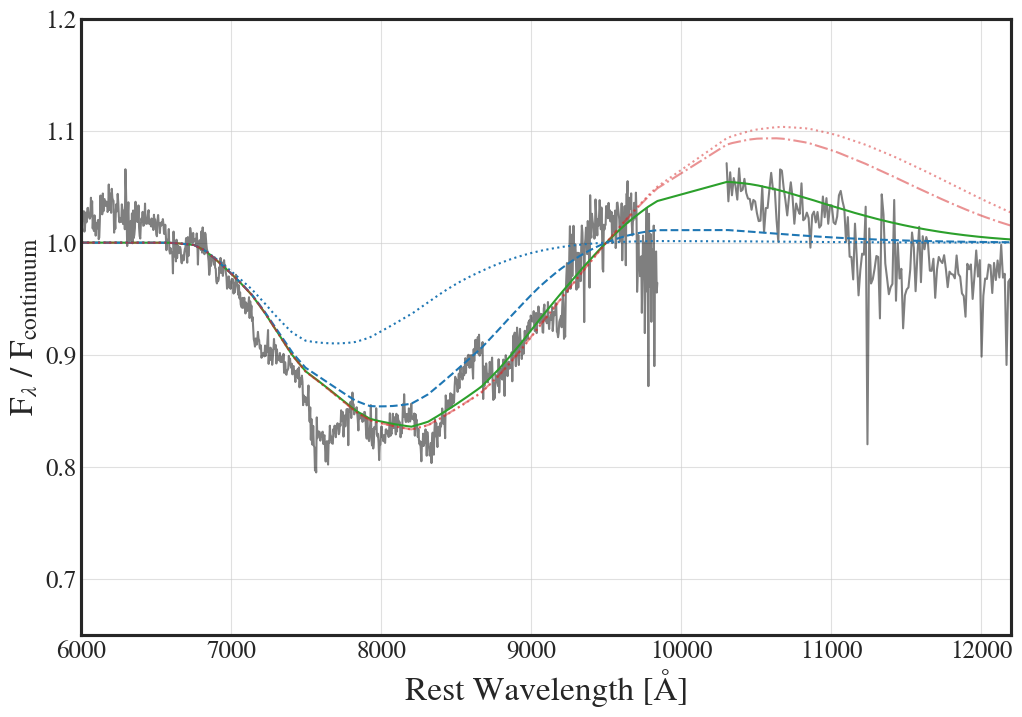

In [21]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl, flux/residual(p_continuum, wl*1e-10), label='X-shooter spectra', color='grey', alpha=0.5)
plt.plot(wl_bin, f_bin/residual(p_continuum, wl_bin*1e-10), label='X-shooter spectra', color='k', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
#plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'F$_{\lambda}$ / F$_{\rm continuum}$'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p.add('t_crit', value=1.43, min=0.1, max=15)
p.add('logne', value=9, min=6, max=15)
#p.add_parameters('logne', 9)
plt.plot(wl, residual(p, wl*1e-10)/residual(p_continuum, wl*1e-10), color='C2' )
p_c = p
p_c['logne'].value = 8
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='--', color='C0' )

p_c = p
p_c['logne'].value = 7
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='dotted', alpha=1, color='C0' )

#p_c = p
#p_c['logne'].value = 6
#plt.plot(wl, residual(p_c, wl*1e-10), ls='dotted', alpha=.1, color='C0' )

p_c = p
p_c['logne'].value = 10
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='-.', alpha=0.5, color='C3' )

p_c = p
p_c['logne'].value = 11
plt.plot(wl, residual(p_c, wl*1e-10)/residual(p_continuum, wl*1e-10), ls='dotted', alpha=0.5, color='C3' )

plt.xlim(6000, 12200)
plt.ylim(0.65, 1.2)
#plt.xscale('log')
#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [9]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p_continuum = emcee_res.params
p_continuum['tau'].value = 0
p_continuum.add('logne', value=9, min=6, max=15)
p_continuum['t0'].value = 1.45
p_continuum.add('t_crit', value=1.45, min=0, max=2)

p_continuum

name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,1.45000000,,,126000,-inf,inf,False
tau,0.00000000,4.75750986,(inf%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


## p

(0.0, 1.5)

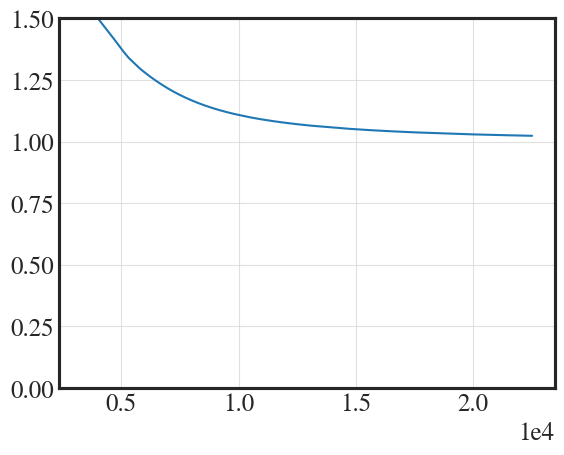

In [7]:
import astropy.units as u
from dust_extinction.parameter_averages import F04
    # initialize the model
ext = F04(Rv=3.1)
ebv = 0.1056
ebv2 = 0.1056+0.10

reddening = ext.extinguish(wl*u.angstrom, Ebv=ebv)/ext.extinguish(wl*u.angstrom, Ebv=ebv2)
plt.plot(wl,reddening)
plt.ylim(0, 1.5)

In [28]:
1/13.8*10036.65+8.1/13.8*10327.311+4.7/13.8*10914.887

10506.365072463768

array([-0.68571248, -0.68569362, -0.68567476, ...,  1.14269516,
        1.14275175,  1.14280833])

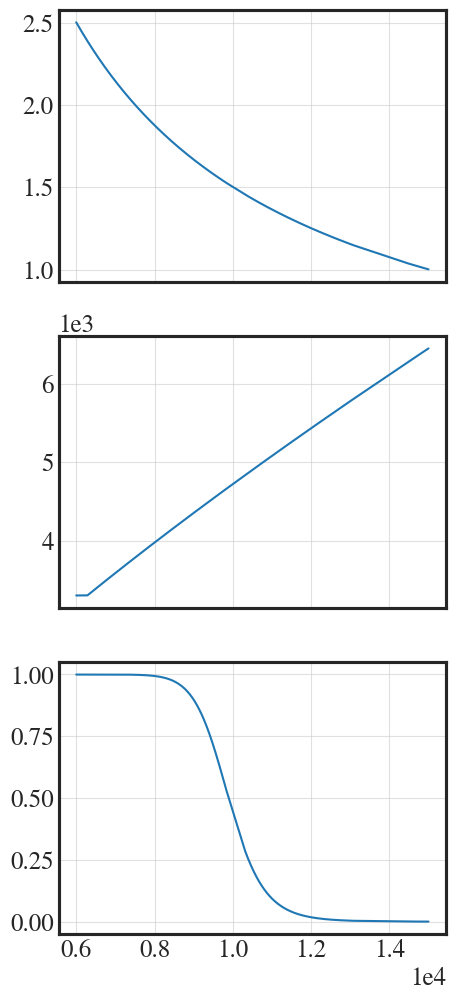

In [8]:
@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    

In [11]:
1.43/0.72, 1.43+9.5/24

(1.9861111111111112, 1.8258333333333332)

In [189]:
9.5/24

0.3958333333333333

In [9]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

In [11]:
#p = lmfit.Parameters()
#OB = 'OB2'
#with open("./data/%s_init.json"%OB, 'r') as infile:
#    p.load(infile)

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['T'].value = 6100   
#p['T'].vary = False   
#p['occult'].vary=False; p['occult'].value=1
#p['occult'].vary=False; p['occult'].value=1
#p.add('tau2', value=0.1, min=0, max=10)
#p.add('lam2', value=9000, min=7000, max=12000)
#p
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['cen1'].vary=False; p['cen2'].vary=False; 
    
start = time.time()
#mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
#print(lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
end = time.time()
#print('Time elapsed:',(end-start)/60) 
#mi2.params

In [15]:
print('Distance_free_parameter',lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
mi2.params['T']

Distance_free_parameter 43.4860881393406


<Parameter 'T', value=5448.548403410729, bounds=[2500:7500]>

In [17]:
#5272 = 5550*0.95
print('5 percent below',lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
mi2.params['T']

5 percent below 43.28794869237252


<Parameter 'T', value=5272 (fixed), bounds=[2500:7500]>

In [20]:
#5830 = 5550*1.05
print('5 percent above',lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
mi2.params['T']

5 percent above 46.951463160886405


<Parameter 'T', value=5830 (fixed), bounds=[2500:7500]>

In [23]:
#5000 = 5550*0.9
print('10 percent below',lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
mi2.params['T']

10 percent above 39.331750149608595


<Parameter 'T', value=5000 (fixed), bounds=[2500:7500]>

In [26]:
#6100 = 5550*1.1
print('10 percent above',lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.43))
mi2.params['T']

10 percent above 6.0047926114235795


<Parameter 'T', value=6100 (fixed), bounds=[2500:7500]>

In [19]:
pickle_in = open("./data/Systematic/OB1_No_Gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
p['amp1'].min = 0.0  ; p['amp2'].min = 0.0; 
p['amp1'].value = 0.0; p['amp2'].value = 0.0

p

name,value,standard error,relative error,initial value,min,max,vary
T,5347.55429,0.81623630,(0.02%),5440.8967947121055,2500.00000,7500.00000,True
N,1.4522e-29,1.0989e-32,(0.08%),1.3338150746859284e-29,-inf,inf,True
vphot,0.29131459,4.1697e-04,(0.14%),0.27793590677592556,0.00000000,1.00000000,True
vmax,0.34391788,3.9493e-04,(0.11%),0.3435875538574039,0.00000000,1.00000000,True
t0,126000.000,,(0.11%),126000,-inf,inf,False
tau,59.7260568,16.0201067,(26.82%),19.888946177308384,0.00000000,100.000000,True
vref,0.00000000,,(26.82%),0.0,0.00000000,1.00000000,False
ve,0.07534443,0.00473320,(6.28%),0.08640330243076558,0.00000000,1.00000000,True
occult,3.3552e-04,3.6780e-04,(109.62%),0.011108657158602665,0.00000000,2.00000000,True
amp1,0.00000000,,(109.62%),0.0,0.00000000,5.00000000,False


In [152]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

p.add('logne', value=9, min=6, max=15)
p['occult'].value = 1
p['occult'].vary = False

p

name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,19.8889462,4.75750986,(23.92%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,1.00000000,0.03904019,(3.90%),0.0005456328535526188,0.00000000,2.00000000,False
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


In [155]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 30 #v = p.valuesdict()
res_n = mini.emcee(nwalkers=nwalkers, burn=0, steps=1000, thin=1, params=p, seed=1)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:13<00:00,  1.36it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 81.49910163  75.66312282  62.78282144 109.46863052  97.45560165
 101.00763217 115.34109699  82.55938984  61.26388857  65.57723149
  94.16612968 112.69298523 133.23474179]
Time elapsed [hours]: 0.2038590533203549


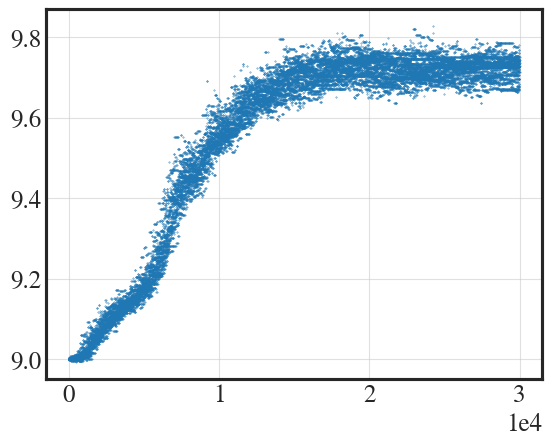

In [156]:
plt.scatter(np.arange(len(res_n.flatchain['logne'])), res_n.flatchain['logne'], s=0.1, color='C0')


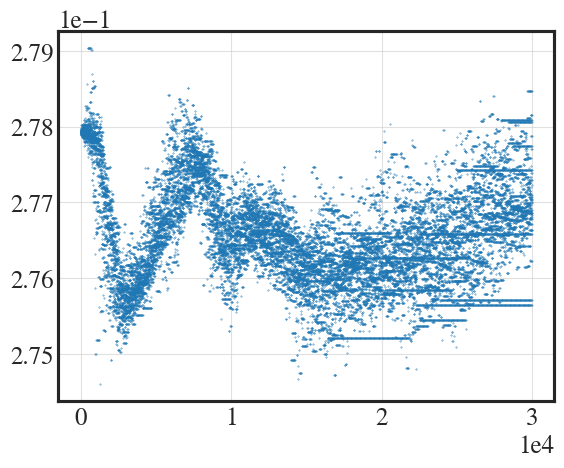

In [157]:
plt.scatter(np.arange(len(res_n.flatchain['logne'])), res_n.flatchain['vphot'], s=0.1, color='C0')


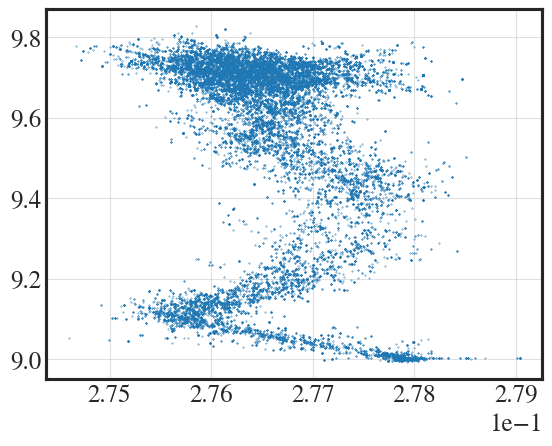

In [158]:
plt.scatter(res_n.flatchain['vphot'], res_n.flatchain['logne'], s=0.1, color='C0')


In [160]:
res_n.params

name,value,standard error,relative error,initial value,min,max,vary
T,5440.75996,1.64887553,(0.03%),5440.8967947121055,2500.00000,7500.00000,True
N,1.3296e-29,1.9736e-32,(0.15%),1.3338150746859284e-29,-inf,inf,True
vphot,0.27650445,6.6961e-04,(0.24%),0.27793590677592556,0.00000000,1.00000000,True
vmax,0.34265593,9.9754e-04,(0.29%),0.3435875538574039,0.00000000,1.00000000,True
t0,126000.000,,,126000,-inf,inf,False
tau,20.4870356,0.50135717,(2.45%),19.888946177308384,0.00000000,100.000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,0.08488783,0.00105362,(1.24%),0.08640330243076558,0.00000000,1.00000000,True
occult,1.00000000,,,1,0.00000000,2.00000000,False
amp1,0.28298451,0.00705262,(2.49%),0.29438175177851106,0.00000000,5.00000000,True


43.59017420089644 0.11365762189712579


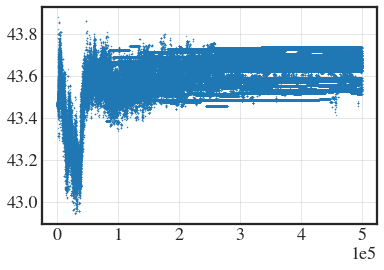

In [13]:
dl = lum_dist_arr(emcee_res.flatchain['N'], emcee_res.flatchain['vphot'], emcee_res.flatchain['vphot'], n_days=1.427)
plt.scatter(np.arange(len(dl)), dl, s=0.1)
print(np.mean(dl), np.std(dl))

43.34144735939319 0.02533598912805333


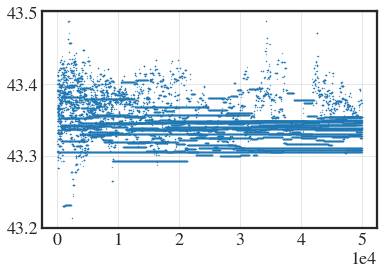

In [22]:
dl_no_gauss = lum_dist_arr(res4.flatchain['N'], res4.flatchain['vphot'], res4.flatchain['vphot'], n_days=1.427)
plt.scatter(np.arange(len(dl_no_gauss)), dl_no_gauss, s=0.1)
print(np.mean(dl_no_gauss), np.std(dl_no_gauss))

#file = "./Data/OB1/Inflated_unc_chi1_100x5000.pkl"
with open("./Data/Systematic/OB1_No_Gaussian_1.pkl", 'wb') as outfile:
    pickle.dump(res4, outfile)

In [10]:
start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
#print('Time elapsed:',(end-start)/60) 
mi2.params

TypeError: lum_dist_arr() got multiple values for argument 'n_days'

In [18]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
p['amp1'].min = 0.0  ; p['amp2'].min = 0.0; 
p['amp1'].value = 0.0; p['amp2'].value = 0.0

start = time.time()
mi3 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
#print('Time elapsed:',(end-start)/60) 
print(lum_dist_arr(mi3.params['N'], mi3.params['vphot'], mi3.params['vphot'], n_days=1.427))
mi3.params

42.5550824610835


name,value,initial value,min,max,vary
T,5361.02263,5440.8967947121055,2500.00000,7500.00000,True
N,1.4330e-29,1.3338150746859284e-29,-inf,inf,True
vphot,0.28206878,0.27793590677592556,0.00000000,1.00000000,True
vmax,0.34112489,0.3435875538574039,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,25.1299198,19.888946177308384,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.08792949,0.08640330243076558,0.00000000,1.00000000,True
occult,0.16352969,0.011108657158602665,0.00000000,2.00000000,True
amp1,0.00000000,0.0,0.00000000,5.00000000,False


In [19]:
print(lum_dist_arr(mi2.params['N'], mi2.params['vphot'], mi2.params['vphot'], n_days=1.427))

43.394858583803526


In [21]:
print(lum_dist_arr(mi3.params['N'], mi3.params['vphot'], mi3.params['vphot'], n_days=1.427))

42.5550824610835


In [27]:
## spectra filtered 
start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

mi2.params

Time elapsed: 0.8558123509089152


name,value,initial value,min,max,vary
T,5448.54840,5440.8967947121055,2500.00000,7500.00000,True
N,1.3223e-29,1.3338150746859284e-29,-inf,inf,True
vphot,0.27473068,0.27793590677592556,0.00000000,1.00000000,True
vmax,0.34260158,0.3435875538574039,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,19.6616783,19.888946177308384,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.08464384,0.08640330243076558,0.00000000,1.00000000,True
occult,0.01046857,0.011108657158602665,0.00000000,2.00000000,True
amp1,0.30484785,0.29438175177851106,0.00000000,5.00000000,True


In [28]:
lum_dist_arr(mi2.params['N'], mi2.params['vphot'])

40.830050563353105

In [34]:
## spectra full 
start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

mi2.params 

Time elapsed: 1.3492989500363668


name,value,initial value,min,max,vary
T,5456.08390,5440.8967947121055,2500.00000,7500.00000,True
N,1.3099e-29,1.3338150746859284e-29,-inf,inf,True
vphot,0.26848538,0.27793590677592556,0.00000000,1.00000000,True
vmax,0.34548020,0.3435875538574039,0.00000000,1.00000000,True
t0,126000.000,126000,-inf,inf,False
tau,21.0343319,19.888946177308384,0.00000000,100.000000,True
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.07883138,0.08640330243076558,0.00000000,1.00000000,True
occult,0.00678771,0.011108657158602665,0.00000000,2.00000000,True
amp1,0.30594854,0.29438175177851106,0.00000000,5.00000000,True
